# Quick CIFAR-100 OptiRoulette Demo

Demo notebook for the OptiRoulette package using fixed defaults and no CLI args.

- Uses OptiRoulette package defaults (no optimizer config passed).
- Uses `torchvision.models` (no `src.models` dependency).
- Downloads CIFAR-100 automatically into `data/cifar100`.
- Demo defaults: `epochs=50`, `batch_size=128`, `model_name=resnet34`.


In [1]:
import random
import subprocess
import sys
from pathlib import Path
from typing import Any, Dict, Optional

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, models as tv_models, transforms


def _pip_install(*packages: str) -> None:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *packages])


try:
    import yaml  # noqa: F401
except ModuleNotFoundError:
    _pip_install('pyyaml')


try:
    import optiroulette  # noqa: F401
except ModuleNotFoundError:
    _pip_install('OptiRoulette')


try:
    import pytorch_optimizer  # noqa: F401
except ModuleNotFoundError:
    _pip_install('pytorch-optimizer')


from optiroulette import OptiRoulette

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


PyTorch: 2.4.1+cu121
CUDA available: True


In [3]:
DEFAULT_AUGMENTATION = {
    "random_crop": True,
    "padding": 4,
    "random_flip": True,
    "color_jitter": {"brightness": 0.1, "contrast": 0.1, "saturation": 0.1, "hue": 0.0},
    "normalize": {"mean": [0.5071, 0.4867, 0.4408], "std": [0.2675, 0.2565, 0.2761]},
    "cutout": True,
    "cutout_size": 8,
    "cutout_n_holes": 1,
    "cutout_p": 1.0,
    "cutout_fill": "zero",
}

seed = 42
data_dir = "data/cifar100"
epochs = 50
batch_size = 128
num_workers = 4
val_split = 0.1
use_val_split = True
split_seed = seed
model_name = "resnet34"
label_smoothing = 0.0
grad_clip = 2.0
use_mixed_precision = True

In [4]:
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


class CutoutTensor:
    """Cutout for tensors (C, H, W). Apply after Normalize."""

    def __init__(
        self,
        size: int = 16,
        n_holes: int = 1,
        p: float = 1.0,
        fill: str = "zero",
        mean: Optional[tuple] = None,
    ):
        if fill not in {"zero", "mean"}:
            raise ValueError("cutout_fill must be 'zero' or 'mean'")
        self.size = size
        self.n_holes = n_holes
        self.p = p
        self.fill = fill
        self.mean = torch.tensor(mean or (0.5071, 0.4867, 0.4408)).view(3, 1, 1)

    def __call__(self, img: torch.Tensor) -> torch.Tensor:
        if torch.rand(()) > self.p or self.n_holes <= 0:
            return img

        _, h, w = img.shape
        fill_val = None if self.fill == "zero" else self.mean.to(img.dtype).to(img.device)

        half = self.size // 2
        for _ in range(self.n_holes):
            y = torch.randint(0, h, (1,), device=img.device).item()
            x = torch.randint(0, w, (1,), device=img.device).item()
            y1 = max(0, y - half)
            y2 = min(h, y + half)
            x1 = max(0, x - half)
            x2 = min(w, x + half)
            if y1 < y2 and x1 < x2:
                if fill_val is None:
                    img[:, y1:y2, x1:x2] = 0.0
                else:
                    img[:, y1:y2, x1:x2] = fill_val
        return img


def build_transforms(aug_cfg: Dict[str, Any], train: bool) -> transforms.Compose:
    aug = aug_cfg or {}
    t_list = []

    if train:
        if aug.get("random_crop", False):
            padding = int(aug.get("padding", 4))
            t_list.append(transforms.RandomCrop(32, padding=padding, padding_mode="reflect"))

        if aug.get("random_flip", False):
            t_list.append(transforms.RandomHorizontalFlip())

        cj = aug.get("color_jitter")
        if isinstance(cj, dict):
            t_list.append(
                transforms.ColorJitter(
                    brightness=cj.get("brightness", 0.1),
                    contrast=cj.get("contrast", 0.1),
                    saturation=cj.get("saturation", 0.1),
                    hue=cj.get("hue", 0.0),
                )
            )

    t_list.append(transforms.ToTensor())

    if "normalize" in aug:
        norm_cfg = aug["normalize"]
        mean = norm_cfg.get("mean", [0.5071, 0.4867, 0.4408])
        std = norm_cfg.get("std", [0.2675, 0.2565, 0.2761])
    else:
        mean = [0.5071, 0.4867, 0.4408]
        std = [0.2675, 0.2565, 0.2761]
    t_list.append(transforms.Normalize(mean=mean, std=std))

    if train and aug.get("cutout", False):
        size = int(aug.get("cutout_size", 16))
        n_holes = int(aug.get("cutout_n_holes", 1))
        p = float(aug.get("cutout_p", 1.0))
        fill = str(aug.get("cutout_fill", "zero"))
        t_list.append(CutoutTensor(size=size, n_holes=n_holes, p=p, fill=fill, mean=tuple(mean)))

    return transforms.Compose(t_list)


def build_dataloaders(
    data_dir: str,
    batch_size: int,
    num_workers: int,
    val_split: float,
    seed: int,
    aug_cfg: Dict[str, Any],
    use_val_split: bool = True,
    split_seed: Optional[int] = None,
) -> Dict[str, DataLoader]:
    tfms = {
        "train": build_transforms(aug_cfg, train=True),
        "test": build_transforms(aug_cfg, train=False),
    }
    train_dataset = datasets.CIFAR100(root=data_dir, train=True, download=True, transform=tfms["train"])
    test_dataset = datasets.CIFAR100(root=data_dir, train=False, download=True, transform=tfms["test"])

    if use_val_split and val_split > 0:
        val_size = int(len(train_dataset) * val_split)
        train_size = len(train_dataset) - val_size
        generator = torch.Generator().manual_seed(split_seed or seed)
        train_subset, val_subset = random_split(train_dataset, [train_size, val_size], generator=generator)

        val_full = datasets.CIFAR100(root=data_dir, train=True, download=False, transform=tfms["test"])
        val_dataset = Subset(val_full, val_subset.indices)
    else:
        train_subset = train_dataset
        val_dataset = test_dataset

    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False,
    )
    return {"train": train_loader, "val": val_loader, "test": test_loader}



def create_torchvision_cifar_model(model_name: str, num_classes: int = 100) -> nn.Module:
    """Create a torchvision ResNet with CIFAR-friendly input stem.

    This keeps the convenience of torchvision while approximating the local
    CIFAR ResNet setup (`3x3` stem, stride `1`, no maxpool).
    """
    builders = {
        "resnet18": tv_models.resnet18,
        "resnet34": tv_models.resnet34,
        "resnet50": tv_models.resnet50,
        "resnet101": tv_models.resnet101,
    }
    if model_name not in builders:
        raise ValueError(f"Unsupported model_name: {model_name}. Choose one of {list(builders)}")

    model = builders[model_name](weights=None)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: OptiRoulette,
    criterion: nn.Module,
    device: torch.device,
    scaler: Optional[torch.amp.GradScaler],
    grad_clip: float,
) -> Dict[str, float]:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    use_amp = scaler is not None

    for batch_idx, (images, labels) in enumerate(loader):
        optimizer.on_batch_start(batch_idx)
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device.type, enabled=use_amp):
            outputs = model(images)
            loss = criterion(outputs, labels)

        if use_amp:
            scaler.scale(loss).backward()
            if grad_clip > 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / max(total, 1)
    acc = correct / max(total, 1)
    return {"loss": avg_loss, "accuracy": acc}


@torch.no_grad()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> Dict[str, float]:
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / max(total, 1)
    acc = correct / max(total, 1)
    return {"loss": avg_loss, "accuracy": acc}


In [5]:
set_seed(seed)

device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

if use_mixed_precision and device.type == "cuda":
    scaler = torch.amp.GradScaler("cuda")
else:
    scaler = None

Path(data_dir).mkdir(parents=True, exist_ok=True)

loaders = build_dataloaders(
    data_dir=data_dir,
    batch_size=batch_size,
    num_workers=num_workers,
    val_split=val_split,
    seed=seed,
    aug_cfg=DEFAULT_AUGMENTATION,
    use_val_split=use_val_split,
    split_seed=split_seed,
)

model = create_torchvision_cifar_model(model_name=model_name, num_classes=100).to(device)

# Package defaults for optimizer/pool logic
optimizer = OptiRoulette(model.parameters(), seed=seed)
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

print("Starting OptiRoulette (pip package) CIFAR-100 training")
print(f"Device: {device}")
print(f"Epochs: {epochs} | Batch size: {batch_size}")
print(
    "Switch: "
    f"{getattr(optimizer, 'switch_granularity', 'epoch')} | "
    f"Avoid repeat: {getattr(optimizer, 'avoid_repeat', True)}"
)
if getattr(optimizer, "_warmup_enabled", False):
    print(
        f"Warmup: epochs={getattr(optimizer, 'warmup_epochs', 0)} "
        f"optimizer={getattr(optimizer, 'warmup_optimizer', None)} "
        f"plateau={bool(getattr(optimizer, 'warmup_config', None))} "
        f"drop_after={getattr(optimizer, 'drop_after_warmup', False)}"
    )
if scaler is not None:
    print("Mixed precision: enabled")


Files already downloaded and verified
Files already downloaded and verified
Starting OptiRoulette (pip package) CIFAR-100 training
Device: cuda
Epochs: 50 | Batch size: 128
Switch: epoch | Avoid repeat: True
Warmup: epochs=17 optimizer=sgd plateau=True drop_after=True
Mixed precision: enabled


In [6]:
history = []

for epoch in range(epochs):
    optimizer.reset_epoch_stats()
    optimizer.on_epoch_start(epoch)
    active_name = optimizer.active_optimizer_name

    train_metrics = train_one_epoch(
        model,
        loaders["train"],
        optimizer,
        criterion,
        device,
        scaler,
        grad_clip,
    )
    val_metrics = evaluate(model, loaders["val"], criterion, device)
    selection_counts = optimizer.get_epoch_selection_counts()

    history.append({
        "epoch": epoch + 1,
        "active": active_name,
        "train_loss": train_metrics["loss"],
        "train_acc": train_metrics["accuracy"],
        "val_loss": val_metrics["loss"],
        "val_acc": val_metrics["accuracy"],
        "selections": selection_counts,
    })

    print(
        f"Epoch {epoch + 1:03d} | {active_name.upper()} | "
        f"Train Loss {train_metrics['loss']:.4f} Acc {train_metrics['accuracy']:.4f} | "
        f"Val Loss {val_metrics['loss']:.4f} Val Acc {val_metrics['accuracy']:.4f} | "
        f"Selections {selection_counts}",
        flush=True,
    )
    optimizer.on_epoch_end(val_acc=val_metrics["accuracy"])


Epoch 001 | SGD | Train Loss 3.9503 Acc 0.0920 | Val Loss 3.5668 Val Acc 0.1444 | Selections {'adam': 0, 'adamw': 0, 'sgd': 352, 'nadam': 0, 'Adagrad': 0, 'amsgrad': 0, 'adabelief': 0, 'yogi': 0, 'qhadam': 0, 'adamp': 0, 'novograd': 0, 'lion': 0, 'ranger': 0, 'ranger21': 0, 'adan': 0, 'AdaHessian': 0, 'rmsprop': 0, 'radam': 0, 'adai': 0, 'gravity': 0, 'TAM': 0, 'SPlus': 0, 'Fromage': 0, 'AggMo': 0, 'GaLore': 0, 'ADOPT': 0, 'fira': 0, 'Apollo': 0, 'AccSGD': 0, 'PID': 0, 'ASGD': 0, 'SGDW': 0, 'AdaNorm': 0, 'Nero': 0}
Epoch 002 | SGD | Train Loss 3.3036 Acc 0.1910 | Val Loss 3.0098 Val Acc 0.2490 | Selections {'adam': 0, 'adamw': 0, 'sgd': 352, 'nadam': 0, 'Adagrad': 0, 'amsgrad': 0, 'adabelief': 0, 'yogi': 0, 'qhadam': 0, 'adamp': 0, 'novograd': 0, 'lion': 0, 'ranger': 0, 'ranger21': 0, 'adan': 0, 'AdaHessian': 0, 'rmsprop': 0, 'radam': 0, 'adai': 0, 'gravity': 0, 'TAM': 0, 'SPlus': 0, 'Fromage': 0, 'AggMo': 0, 'GaLore': 0, 'ADOPT': 0, 'fira': 0, 'Apollo': 0, 'AccSGD': 0, 'PID': 0, 'ASGD

In [7]:
test_metrics = evaluate(model, loaders["test"], criterion, device)
print(f"Test Loss {test_metrics['loss']:.4f} | Test Acc {test_metrics['accuracy']:.4f}")

history[-1], test_metrics


Test Loss 0.9206 | Test Acc 0.7524


({'epoch': 50,
  'active': 'ranger',
  'train_loss': 0.2931131163809035,
  'train_acc': 0.9097555555555555,
  'val_loss': 0.9085424450397491,
  'val_acc': 0.7622,
  'selections': {'adam': 0,
   'adamw': 0,
   'sgd': 0,
   'nadam': 0,
   'Adagrad': 0,
   'amsgrad': 0,
   'adabelief': 0,
   'yogi': 0,
   'qhadam': 0,
   'adamp': 0,
   'novograd': 0,
   'lion': 0,
   'ranger': 352,
   'ranger21': 0,
   'adan': 0,
   'AdaHessian': 0,
   'rmsprop': 0,
   'radam': 0,
   'adai': 0,
   'gravity': 0,
   'TAM': 0,
   'SPlus': 0,
   'Fromage': 0,
   'AggMo': 0,
   'GaLore': 0,
   'ADOPT': 0,
   'fira': 0,
   'Apollo': 0,
   'AccSGD': 0,
   'PID': 0,
   'ASGD': 0,
   'SGDW': 0,
   'AdaNorm': 0,
   'Nero': 0}},
 {'loss': 0.9205869375228882, 'accuracy': 0.7524})

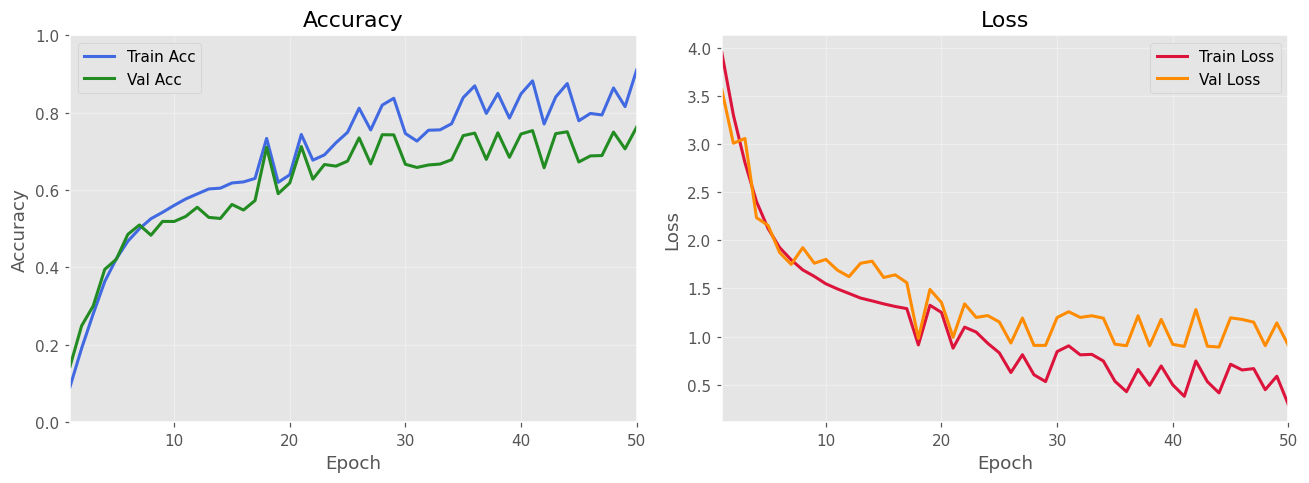

In [8]:
# Accuracy/Loss plots
if not history:
    print('No training history found. Run the training cell first.')
else:
    epochs_axis = [h['epoch'] for h in history]
    train_acc = [h['train_acc'] for h in history]
    val_acc = [h['val_acc'] for h in history]
    train_loss = [h['train_loss'] for h in history]
    val_loss = [h['val_loss'] for h in history]

    plt.style.use('ggplot')
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), dpi=110)

    ax = axes[0]
    ax.plot(epochs_axis, train_acc, color='royalblue', linewidth=2, label='Train Acc')
    ax.plot(epochs_axis, val_acc, color='forestgreen', linewidth=2, label='Val Acc')
    ax.set_title('Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_xlim(1, max(epochs_axis))
    ax.set_ylim(0.0, 1.0)
    ax.grid(True, alpha=0.35)
    ax.legend(loc='best')

    ax = axes[1]
    ax.plot(epochs_axis, train_loss, color='crimson', linewidth=2, label='Train Loss')
    ax.plot(epochs_axis, val_loss, color='darkorange', linewidth=2, label='Val Loss')
    ax.set_title('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_xlim(1, max(epochs_axis))
    ax.grid(True, alpha=0.35)
    ax.legend(loc='best')

    fig.tight_layout()
    plt.show()
